In [1]:
import os
import pandas as pd
import json
import torch
import numpy as np

import seaborn as sns
sns.set()


log_path = "./test"    

In [2]:

def load_row(mesh_name, exp_path):

    # load params.json
    with open(os.path.join(exp_path, "params.json")) as f:
        params = json.load(f)

    # load summary.json
    with open(os.path.join(exp_path, "summary.json")) as f:
        summary = json.load(f)
    # load delta
    ckpt_path = os.path.join(exp_path, "checkpoints", f"{mesh_name}.ckpt")
    delta = torch.load(ckpt_path, map_location=torch.device('cpu'))

    return params, summary, delta



In [6]:
data = []

no_sal = -1

for mesh in os.listdir(log_path):

    if not os.path.isdir(os.path.join(log_path,mesh)) or 'sal_mesh' in mesh:
        continue

    mesh_path = os.path.join(log_path, mesh, "pgd_attack")
    
    for exp in os.listdir(mesh_path):
        exp_path = os.path.join(mesh_path, exp, "version_0")
        try:
            params, summary, delta = load_row(mesh, exp_path)
        except Exception as e:
            print(f"MISSING {exp_path}: {getattr(e, 'message', repr(e))}")
            continue
        n_pixels = (delta != 0.).sum().to(dtype=torch.float32) / delta.numel()
        n_pixels = float(n_pixels)
        data.append({
            "name": mesh if mesh != "toilet_paper" else "paper_tissue",
            **params,
            **summary,
            "n_pixels": n_pixels
        })

df = pd.DataFrame(data)

df['saliency_threshold'].fillna(no_sal, inplace=True)
df

        

,name,eps,alpha,model,saliency,texture_rescale,pytorch_no_attack,pytorch_attack,sailenv_no_attack,sailenv_attack,n_pixels,saliency_threshold
0,candle,0.05,0.01,inception,False,0.33,1.000000,0.000000,0.983333,0.616667,0.469659,-1.00
1,candle,0.05,0.01,inception,True,0.33,1.000000,0.000000,0.983333,0.666667,0.426446,0.05
2,candle,0.05,0.01,inception,True,0.33,1.000000,0.116667,0.983333,0.750000,0.193098,0.20
3,candle,0.05,0.01,mobilenet,False,0.33,0.566667,0.000000,0.483333,0.116667,0.354249,-1.00
4,candle,0.05,0.01,mobilenet,True,0.33,0.566667,0.000000,0.483333,0.166667,0.317165,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...
175,paper_tissue,0.50,0.01,inception,True,0.33,0.050000,0.000000,0.283333,0.283333,0.094681,0.05
176,paper_tissue,0.50,0.01,inception,True,0.33,0.050000,0.000000,0.283333,0.233333,0.013456,0.20
177,paper_tissue,0.50,0.01,mobilenet,False,0.33,0.216667,0.000000,0.316667,0.000000,0.230265,-1.00
178,paper_tissue,0.50,0.01,mobilenet,True,0.33,0.216667,0.000000,0.316667,0.183333,0.183038,0.05


In [7]:
# add accuracy drop

df['sailenv_acc_drop'] = (df['sailenv_no_attack'] - df['sailenv_attack']) / df['sailenv_no_attack']
df['pytorch_acc_drop'] = (df['pytorch_no_attack'] - df['pytorch_attack']) / df['pytorch_no_attack']

df[df['name']=='toilet_paper']

,name,eps,alpha,model,saliency,texture_rescale,pytorch_no_attack,pytorch_attack,sailenv_no_attack,sailenv_attack,n_pixels,saliency_threshold,sailenv_acc_drop,pytorch_acc_drop


In [8]:
inception_df = df[df['model'] == 'inception']
pivoted = df.pivot(index=['model','eps',"saliency_threshold"], columns="name", values=["sailenv_acc_drop", "pytorch_acc_drop", 'n_pixels'])

pivoted

sailenv_acc_drop                       \
name                                        candle      ewer lamp_floor   
model     eps  saliency_threshold                                         
inception 0.05 -1.00                      0.372881  0.866667  -0.115385   
                0.05                      0.322034  0.733333  -0.096154   
                0.20                      0.237288  0.166667  -0.057692   
          0.10 -1.00                      0.406780  0.766667  -0.153846   
                0.05                      0.372881  0.800000  -0.153846   
                0.20                      0.372881  0.233333  -0.096154   
          0.50 -1.00                      0.389830  0.733333  -0.076923   
                0.05                      0.440678  0.666667  -0.153846   
                0.20                      0.355932  0.133333  -0.076923   
mobilenet 0.05 -1.00                      0.758621       NaN   0.616667   
                0.05                      0.655172       NaN   0.650000   
                0.20                      0.241379       NaN   0.683333   
          0.10 -1.00                      0.724138       NaN   0.616667   
                0.05                      0.724138       NaN   0.683333   
                0.20                      0.413793       NaN   0.683333   
          0.50 -1.00                      0.758621       NaN   0.616667   
                0.05                      0.655172       NaN   0.650000   
                0.20                      0.241379       NaN   0.683333   

                                                                    \
name                              paper_tissue   plunger       pot   
model     eps  saliency_threshold                                    
inception 0.05 -1.00                  0.647059  0.066667  0.000000   
                0.05                  0.000000  0.066667  0.060606   
                0.20                  0.235294  0.016667  0.000000   
          0.10 -1.00                  0.647059  0.083333  0.212121   
                0.05                  0.117647  0.116667 -0.060606   
                0.20                  0.352941  0.016667 -0.030303   
          0.50 -1.00                  0.647059  0.116667  0.090909   
                0.05                  0.000000  0.116667  0.121212   
                0.20                  0.176471  0.016667 -0.030303   
mobilenet 0.05 -1.00                  1.000000  0.723404  0.600000   
                0.05                 -0.263158  0.659574  0.325000   
                0.20                  0.105263  0.638298  0.250000   
          0.10 -1.00                  1.000000  0.744681  0.650000   
                0.05                 -0.315789  0.659574  0.350000   
                0.20                  0.210526  0.617021  0.275000   
          0.50 -1.00                  1.000000  0.744681  0.675000   
                0.05                  0.421053  0.638298  0.350000   
                0.20                  0.157895  0.595745  0.275000   

                                                                       \
name                              remote_controller table_living_room   
model     eps  saliency_threshold                                       
inception 0.05 -1.00                       0.101695          0.162791   
                0.05                       0.086207          0.116279   
                0.20                       0.017241          0.000000   
          0.10 -1.00                       0.338983          0.465116   
                0.05                       0.155172          0.627907   
                0.20                       0.017241          0.046512   
          0.50 -1.00                       0.406780          0.418605   
                0.05                       0.258621          0.651163   
                0.20                       0.034483          0.162791   
mobilenet 0.05 -1.00                       0.206897          0.000000   
                0.05                  

In [9]:
# print acc_drop table
acc_drop_df = pivoted['pytorch_acc_drop'].loc[:,:,no_sal].copy()
acc_drop_df['avg'] = acc_drop_df.mean(numeric_only=True, axis=1)
print(acc_drop_df.round(2).to_latex())

\begin{tabular}{llrrrrrrrrrrr}
\toprule
          & name &  candle &  ewer &  lamp\_floor &  paper\_tissue &  plunger &   pot &  remote\_controller &  table\_living\_room &  tennis\_racket &  toilet &   avg \\
model & eps &         &       &             &               &          &       &                    &                    &                &         &       \\
\midrule
inception & 0.05 &     1.0 &   1.0 &        0.98 &           1.0 &     1.00 &  0.97 &               0.95 &               1.00 &           0.05 &     1.0 &  0.89 \\
          & 0.10 &     1.0 &   1.0 &        0.95 &           1.0 &     0.98 &  0.97 &               1.00 &               0.97 &           0.45 &     1.0 &  0.93 \\
          & 0.50 &     1.0 &   1.0 &        1.00 &           1.0 &     1.00 &  0.94 &               0.97 &               1.00 &           0.97 &     1.0 &  0.99 \\
mobilenet & 0.05 &     1.0 &   NaN &        0.86 &           1.0 &     1.00 &  1.00 &               0.98 &               0.95 &   

In [10]:
acc_drop_df

name            candle  ewer  lamp_floor  paper_tissue   plunger       pot  \
model     eps                                                                
inception 0.05     1.0   1.0    0.976190           1.0  1.000000  0.971429   
          0.10     1.0   1.0    0.952381           1.0  0.981132  0.972222   
          0.50     1.0   1.0    1.000000           1.0  1.000000  0.942857   
mobilenet 0.05     1.0   NaN    0.860000           1.0  1.000000  1.000000   
          0.10     1.0   NaN    0.860000           1.0  1.000000  1.000000   
          0.50     1.0   NaN    0.860000           1.0  1.000000  1.000000   

name            remote_controller  table_living_room  tennis_racket  toilet  \
model     eps                                                                 
inception 0.05           0.948276           1.000000       0.050000     1.0   
          0.10           1.000000           0.972973       0.450000     1.0   
          0.50           0.965517           1.000000       0.966667     1.0   
mobilenet 0.05           0.981818           0.947368       0.923077     1.0   
          0.10           0.981818           1.000000       1.000000     1.0   
          0.50           1.000000           0.947368       1.000000     1.0   

name                 avg  
model     eps             
inception 0.05  0.894589  
          0.10  0.932871  
          0.50  0.987504  
mobilenet 0.05  0.968029  
          0.10  0.982424  
          0.50  0.978596

In [11]:
# print sailenv_acc_drop table
acc_drop_df = pivoted['sailenv_acc_drop'].loc[:,:,no_sal].copy()
acc_drop_df['avg'] = acc_drop_df.mean(numeric_only=True, axis=1)
print(acc_drop_df.round(2).to_latex())

\begin{tabular}{llrrrrrrrrrrr}
\toprule
          & name &  candle &  ewer &  lamp\_floor &  paper\_tissue &  plunger &   pot &  remote\_controller &  table\_living\_room &  tennis\_racket &  toilet &   avg \\
model & eps &         &       &             &               &          &       &                    &                    &                &         &       \\
\midrule
inception & 0.05 &    0.37 &  0.87 &       -0.12 &          0.65 &     0.07 &  0.00 &               0.10 &               0.16 &           0.00 &     1.0 &  0.31 \\
          & 0.10 &    0.41 &  0.77 &       -0.15 &          0.65 &     0.08 &  0.21 &               0.34 &               0.47 &           0.00 &     1.0 &  0.38 \\
          & 0.50 &    0.39 &  0.73 &       -0.08 &          0.65 &     0.12 &  0.09 &               0.41 &               0.42 &           0.07 &     1.0 &  0.38 \\
mobilenet & 0.05 &    0.76 &   NaN &        0.62 &          1.00 &     0.72 &  0.60 &               0.21 &               0.00 &   

In [12]:
acc_drop_df

name              candle      ewer  lamp_floor  paper_tissue   plunger  \
model     eps                                                            
inception 0.05  0.372881  0.866667   -0.115385      0.647059  0.066667   
          0.10  0.406780  0.766667   -0.153846      0.647059  0.083333   
          0.50  0.389830  0.733333   -0.076923      0.647059  0.116667   
mobilenet 0.05  0.758621       NaN    0.616667      1.000000  0.723404   
          0.10  0.724138       NaN    0.616667      1.000000  0.744681   
          0.50  0.758621       NaN    0.616667      1.000000  0.744681   

name                 pot  remote_controller  table_living_room  tennis_racket  \
model     eps                                                                   
inception 0.05  0.000000           0.101695           0.162791       0.000000   
          0.10  0.212121           0.338983           0.465116       0.000000   
          0.50  0.090909           0.406780           0.418605       0.066667   
mobilenet 0.05  0.600000           0.206897           0.000000       0.806452   
          0.10  0.650000           0.431034           0.000000       0.903226   
          0.50  0.675000           0.413793           0.000000       0.935484   

name            toilet       avg  
model     eps                     
inception 0.05     1.0  0.310237  
          0.10     1.0  0.376621  
          0.50     1.0  0.379293  
mobilenet 0.05     NaN  0.589005  
          0.10     NaN  0.633718  
          0.50     NaN  0.643031

In [13]:
# print n_pixels table
npixels_df = pivoted['n_pixels'].copy()
npixels_df['avg'] = npixels_df.mean(numeric_only=True, axis=1)
print(npixels_df.round(2).to_latex())

\begin{tabular}{lllrrrrrrrrrrr}
\toprule
          &      & name &  candle &  ewer &  lamp\_floor &  paper\_tissue &  plunger &   pot &  remote\_controller &  table\_living\_room &  tennis\_racket &  toilet &   avg \\
model & eps & saliency\_threshold &         &       &             &               &          &       &                    &                    &                &         &       \\
\midrule
inception & 0.05 & -1.00 &    0.47 &  0.36 &        0.20 &          0.16 &     0.39 &  0.23 &               0.37 &               0.42 &           0.23 &    0.17 &  0.30 \\
          &      &  0.05 &    0.43 &  0.28 &        0.19 &          0.09 &     0.36 &  0.08 &               0.37 &               0.24 &           0.22 &    0.13 &  0.24 \\
          &      &  0.20 &    0.19 &  0.04 &        0.02 &          0.01 &     0.15 &  0.00 &               0.05 &               0.01 &           0.05 &    0.01 &  0.05 \\
          & 0.10 & -1.00 &    0.49 &  0.37 &        0.18 &          0.16 &  

In [14]:
npixels_df

name                                 candle      ewer  lamp_floor  \
model     eps  saliency_threshold                                   
inception 0.05 -1.00               0.469659  0.360107    0.203750   
                0.05               0.426446  0.279526    0.189072   
                0.20               0.193098  0.040698    0.017229   
          0.10 -1.00               0.488497  0.372851    0.183642   
                0.05               0.413631  0.259850    0.176524   
                0.20               0.182410  0.041986    0.021159   
          0.50 -1.00               0.408695  0.397947    0.203439   
                0.05               0.385747  0.296462    0.179738   
                0.20               0.185882  0.042942    0.019806   
mobilenet 0.05 -1.00               0.354249  0.000000    0.103344   
                0.05               0.317165  0.000000    0.099522   
                0.20               0.110473  0.000000    0.083247   
          0.10 -1.00               0.354025  0.000000    0.103344   
                0.05               0.321523  0.000000    0.099969   
                0.20               0.120158  0.000000    0.080653   
          0.50 -1.00               0.354580  0.000000    0.103353   
                0.05               0.320578  0.000000    0.099578   
                0.20               0.124646  0.000000    0.085452   

name                               paper_tissue   plunger       pot  \
model     eps  saliency_threshold                                     
inception 0.05 -1.00                   0.158242  0.389479  0.227719   
                0.05                   0.094654  0.355064  0.077641   
                0.20                   0.012743  0.151242  0.001264   
          0.10 -1.00                   0.158471  0.400817  0.223518   
                0.05                   0.094922  0.348935  0.071886   
                0.20                   0.014235  0.150900  0.001434   
          0.50 -1.00                   0.158602  0.377551  0.224919   
                0.05                   0.094681  0.351722  0.072582   
                0.20                   0.013456  0.151195  0.001938   
mobilenet 0.05 -1.00                   0.227460  0.366993  0.206417   
                0.05                   0.128799  0.313197  0.097255   
                0.20                   0.010310  0.107355  0.005334   
          0.10 -1.00                   0.227409  0.371280  0.201342   
                0.05                   0.131022  0.309689  0.097037   
                0.20                   0.008902  0.107769  0.005334   
          0.50 -1.00                   0.230265  0.371280  0.208718   
                0.05                   0.183038  0.313693  0.108756   
                0.20                   0.008360  0.107403  0.005452   

name                               remote_controller  table_living_room  \
model     eps  saliency_threshold                                         
inception 0.05 -1.00                        0.373081           0.416736   
                0.05                        0.372171           0.243147   
                0.20                        0.048428           0.007693   
          0.10 -1.00                        0.447533           0.381812   
                0.05                        0.396684           0.226623   
                0.20                        0.049326           0.006351   
          0.50 -1.00                        0.450580           0.382566   
                0.05                        0.381124           0.230227   
                0.20                        0.084910           0.006713   
mobilenet 0.05 -1.00                        0.429215           0.298019   
                0.05                        0.363166           0.198070   
                0.20                        0.076773           0.017927   
          0.10 -1.00                        0.372042           0.305612   
                0.05                        0.339386           0.192820  

In [15]:
pivoted

sailenv_acc_drop                       \
name                                        candle      ewer lamp_floor   
model     eps  saliency_threshold                                         
inception 0.05 -1.00                      0.372881  0.866667  -0.115385   
                0.05                      0.322034  0.733333  -0.096154   
                0.20                      0.237288  0.166667  -0.057692   
          0.10 -1.00                      0.406780  0.766667  -0.153846   
                0.05                      0.372881  0.800000  -0.153846   
                0.20                      0.372881  0.233333  -0.096154   
          0.50 -1.00                      0.389830  0.733333  -0.076923   
                0.05                      0.440678  0.666667  -0.153846   
                0.20                      0.355932  0.133333  -0.076923   
mobilenet 0.05 -1.00                      0.758621       NaN   0.616667   
                0.05                      0.655172       NaN   0.650000   
                0.20                      0.241379       NaN   0.683333   
          0.10 -1.00                      0.724138       NaN   0.616667   
                0.05                      0.724138       NaN   0.683333   
                0.20                      0.413793       NaN   0.683333   
          0.50 -1.00                      0.758621       NaN   0.616667   
                0.05                      0.655172       NaN   0.650000   
                0.20                      0.241379       NaN   0.683333   

                                                                    \
name                              paper_tissue   plunger       pot   
model     eps  saliency_threshold                                    
inception 0.05 -1.00                  0.647059  0.066667  0.000000   
                0.05                  0.000000  0.066667  0.060606   
                0.20                  0.235294  0.016667  0.000000   
          0.10 -1.00                  0.647059  0.083333  0.212121   
                0.05                  0.117647  0.116667 -0.060606   
                0.20                  0.352941  0.016667 -0.030303   
          0.50 -1.00                  0.647059  0.116667  0.090909   
                0.05                  0.000000  0.116667  0.121212   
                0.20                  0.176471  0.016667 -0.030303   
mobilenet 0.05 -1.00                  1.000000  0.723404  0.600000   
                0.05                 -0.263158  0.659574  0.325000   
                0.20                  0.105263  0.638298  0.250000   
          0.10 -1.00                  1.000000  0.744681  0.650000   
                0.05                 -0.315789  0.659574  0.350000   
                0.20                  0.210526  0.617021  0.275000   
          0.50 -1.00                  1.000000  0.744681  0.675000   
                0.05                  0.421053  0.638298  0.350000   
                0.20                  0.157895  0.595745  0.275000   

                                                                       \
name                              remote_controller table_living_room   
model     eps  saliency_threshold                                       
inception 0.05 -1.00                       0.101695          0.162791   
                0.05                       0.086207          0.116279   
                0.20                       0.017241          0.000000   
          0.10 -1.00                       0.338983          0.465116   
                0.05                       0.155172          0.627907   
                0.20                       0.017241          0.046512   
          0.50 -1.00                       0.406780          0.418605   
                0.05                       0.258621          0.651163   
                0.20                       0.034483          0.162791   
mobilenet 0.05 -1.00                       0.206897          0.000000   
                0.05                  

In [16]:
df = pivoted.loc["inception"]
senv_drop = df['sailenv_acc_drop']
p3d_drop = df['pytorch_acc_drop']
npixels = df['n_pixels']


[5. 5.]


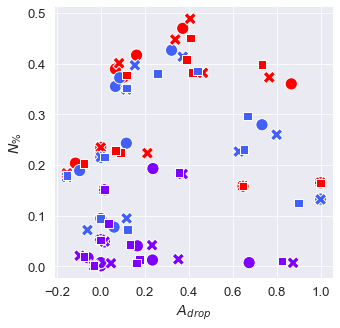

[5. 5.]


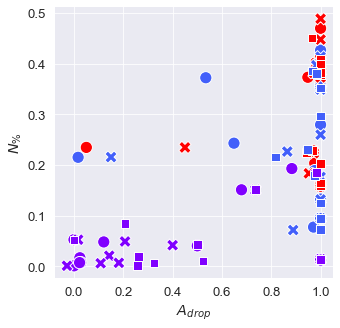

[5. 5.]


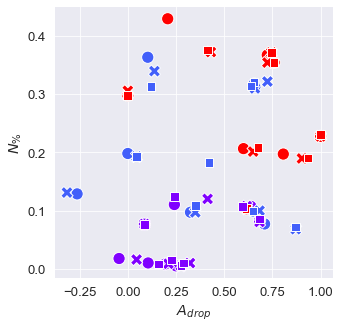

[5. 5.]


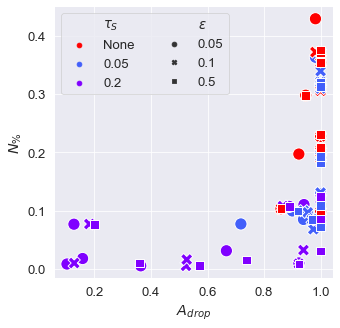

In [22]:
# do scatter plots
import matplotlib.pyplot as plt

sns.set_theme()
sns.set_context("paper",font_scale=1.5)
sns.color_palette("rocket", as_cmap=True)

def flatten_df(df, col_name="value"):
    df = df.reset_index(('saliency_threshold', 'eps'))
    df = pd.concat([df[['eps','saliency_threshold',col]].rename(columns={col: col_name}) for col in df if col != "toilet_paper"]).reset_index()
    del df['index']
    df = df.fillna(0)
    return df



models = pivoted.index.unique('model')
epsilons = pivoted.index.unique('eps')
threshes = pivoted.index.unique('saliency_threshold')

where_legend = 4

curr_plot = 1
for model in models:
    
    model_df = pivoted.loc[model]
    model_df = model_df.stack()

    eps_key = "$\\epsilon$"
    sal_key = "$\\tau_S$"

    model_df = model_df.rename_axis(index={'eps': eps_key, 'saliency_threshold': sal_key})

    for renderer in ['sailenv', 'pytorch']:
        key = f"{renderer}_acc_drop"
        plt.figure(figsize=(5.,5.))
        #plt.title(f"{renderer.capitalize()} on {model.capitalize()}")
        #plt.tight_layout()
        g = sns.scatterplot(data=model_df, 
            x=key, y='n_pixels',
            hue=sal_key, style=eps_key,
            palette="rainbow_r",
            s=150,
            legend=(curr_plot == where_legend)
            )
        g.set_xlabel("$A_{drop}$")
        g.set_ylabel("$N_\%$")

        if curr_plot == where_legend:        
            g.legend(loc='upper left', ncol=2)
            g.get_legend().texts[1]._text = 'None'
        plt.savefig(f"./test/scatter_{model}_{renderer}.pdf", bbox_inches="tight")
        print(g.get_figure().get_size_inches())
        plt.show()

        #bbox  = g.get_legend().get_window_extent().transformed(g.get_figure().dpi_scale_trans.inverted())
        #g.get_figure().savefig("./test/legend.pdf", dpi="figure", bbox_inches=bbox)
        plt.close(g.get_figure())
        curr_plot += 1


